# DCGAN - Deep Convolutional GANs

- [DCGAN paper link](https://arxiv.org/abs/1511.06434)

DCGAN (Deep Convolutional Generative Adversarial Network) has several unique features that distinguish it from traditional GAN architectures. Here are some of the key characteristics of DCGAN:

- Convolutional Architecture: DCGAN utilizes convolutional layers in both the generator and discriminator networks instead of fully connected layers. This allows the model to effectively capture spatial information and generate high-resolution images.

- Strided Convolutions and Transposed Convolutions: DCGAN uses strided convolutions in the discriminator to downsample the input and transposed convolutions in the generator to upsample the noise input. This helps in learning hierarchical representations and generating higher-resolution images.

- Batch Normalization: DCGAN applies batch normalization to the activations in both the generator and discriminator networks. It helps in stabilizing the training process and accelerates convergence by normalizing the inputs to each layer.

- LeakyReLU Activation: DCGAN employs LeakyReLU activation in the discriminator network instead of traditional ReLU. LeakyReLU allows for non-zero gradients for negative inputs, preventing the "dying ReLU" problem and improving the flow of gradients during training.

- No Fully Connected Layers: DCGAN does not use fully connected layers in the discriminator or generator. Instead, it relies on convolutional layers and global pooling to reduce the spatial dimensions of the activations.

- Random Noise Input: DCGAN takes random noise as input to the generator network. This noise vector is typically sampled from a uniform or normal distribution and serves as the source of randomness for generating diverse images.

These unique characteristics make DCGAN well-suited for generating high-quality and realistic images. It has been widely used in various applications, including image synthesis, image-to-image translation, and style transfer.








In [13]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [14]:
# Generator
def make_generator_model():
    inputs = tf.keras.Input(shape=(100,))
    x = layers.Dense(7*7*256, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((7, 7, 256))(x)
    assert x.shape == (None, 7, 7, 256)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    assert x.shape == (None, 7, 7, 128)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    assert x.shape == (None, 14, 14, 64)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    assert x.shape == (None, 28, 28, 1)

    generator = tf.keras.Model(inputs=inputs, outputs=x)
    return generator


In [15]:
# Discriminator
def make_discriminator_model():
    inputs = tf.keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    discriminator = tf.keras.Model(inputs=inputs, outputs=x)
    return discriminator

In [16]:
# Create the generator and discriminator models
generator = make_generator_model()
discriminator = make_discriminator_model()

In [17]:
# Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([tf.shape(images)[0], 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [22]:
# data Loading & preprocessing

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size=128)

In [23]:
# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        if epoch:

            print(f"Current epoch is {epoch}")

            # Generate samples after each epoch
            random_latent_vectors = tf.random.normal([10, 100])
            generated_images = generator(random_latent_vectors, training=False)

            # Reshape the generated images
            generated_images = generated_images.numpy().reshape(-1, 28, 28)

            # Display the generated images
            plt.figure(figsize=(10, 1))
            for i in range(10):
                plt.subplot(1, 10, i + 1)
                plt.imshow(generated_images[i], cmap='gray')
                plt.axis('off')
            plt.show()

Current epoch is 1


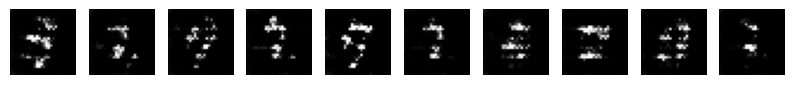

Current epoch is 2


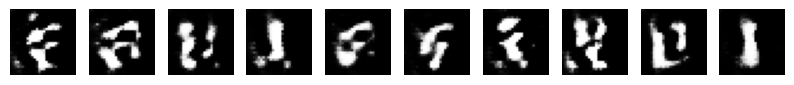

Current epoch is 3


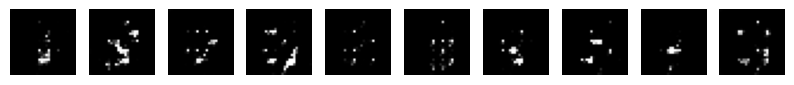

Current epoch is 4


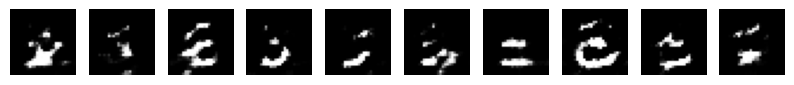

Current epoch is 5


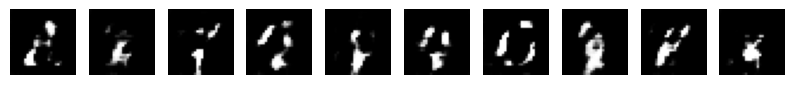

Current epoch is 6


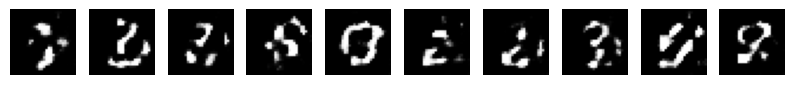

Current epoch is 7


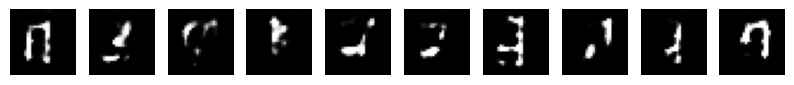

Current epoch is 8


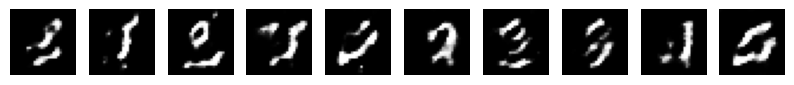

Current epoch is 9


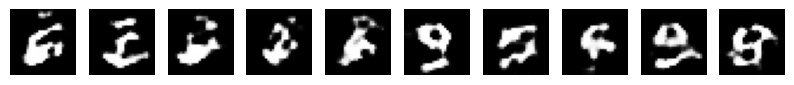

Current epoch is 10


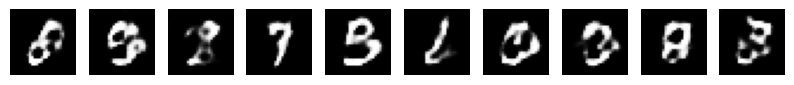

Current epoch is 11


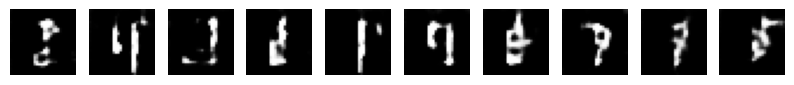

Current epoch is 12


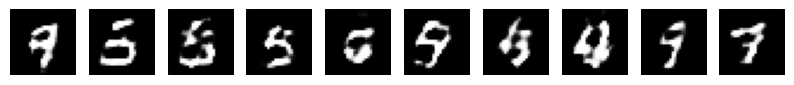

Current epoch is 13


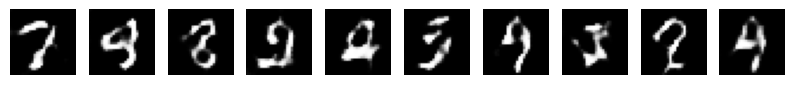

Current epoch is 14


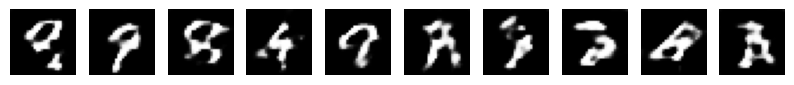

Current epoch is 15


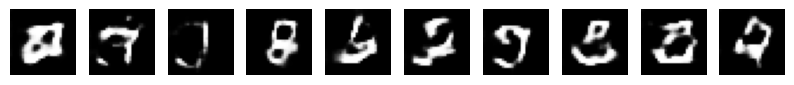

Current epoch is 16


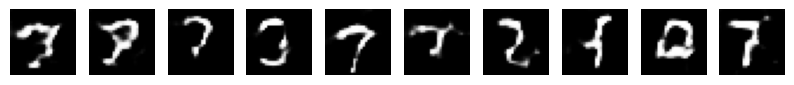

Current epoch is 17


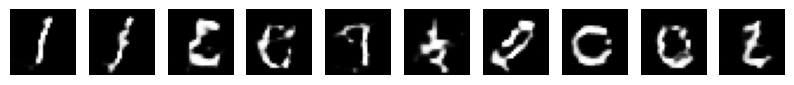

Current epoch is 18


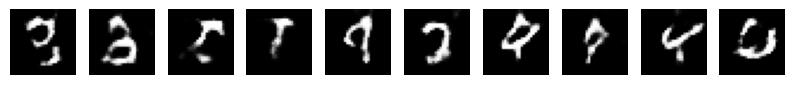

Current epoch is 19


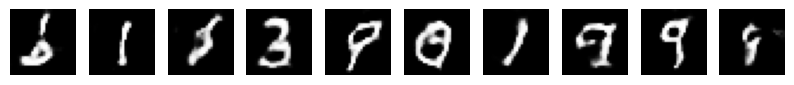

Current epoch is 20


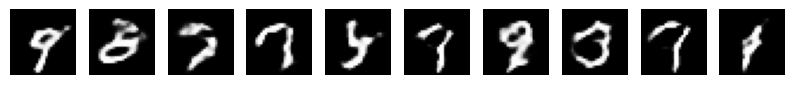

Current epoch is 21


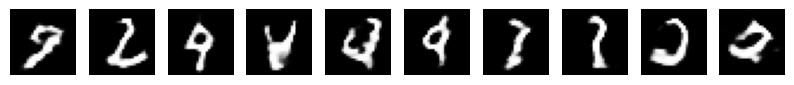

Current epoch is 22


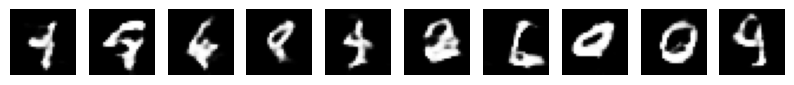

Current epoch is 23


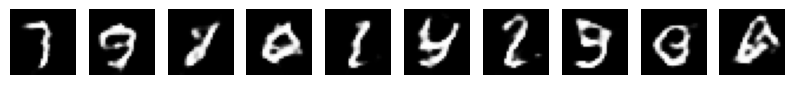

Current epoch is 24


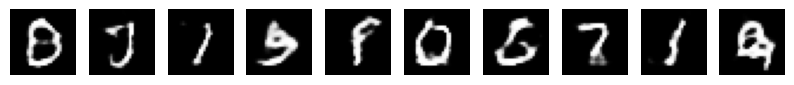

Current epoch is 25


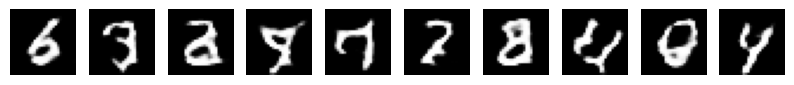

Current epoch is 26


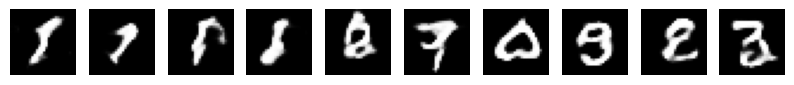

Current epoch is 27


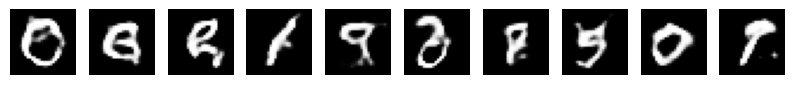

Current epoch is 28


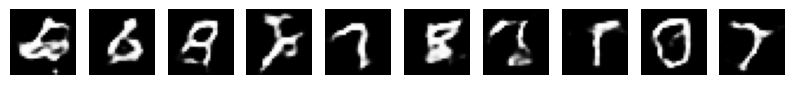

Current epoch is 29


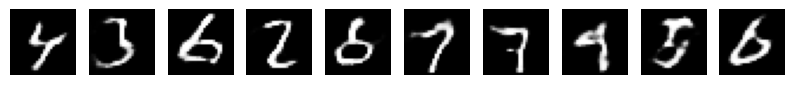

Current epoch is 30


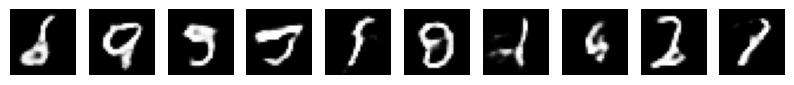

Current epoch is 31


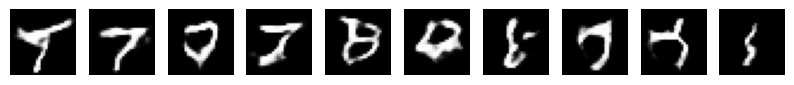

Current epoch is 32


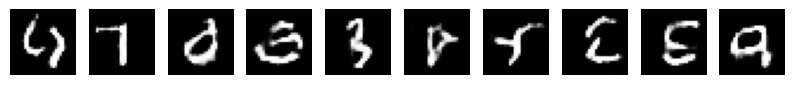

Current epoch is 33


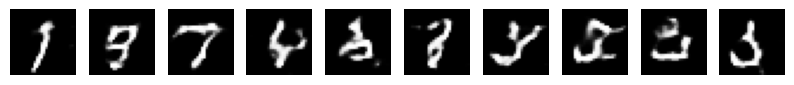

Current epoch is 34


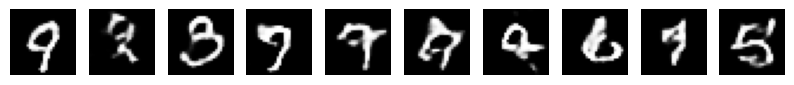

Current epoch is 35


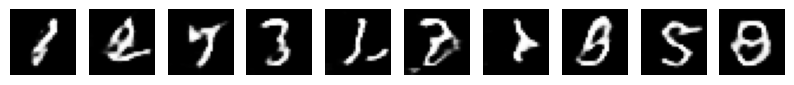

Current epoch is 36


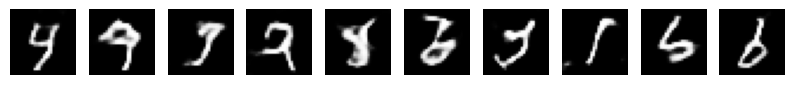

Current epoch is 37


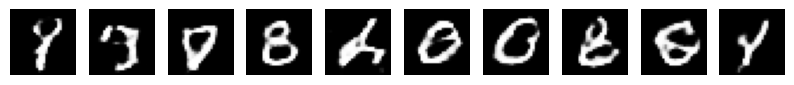

Current epoch is 38


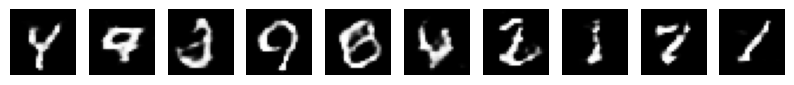

Current epoch is 39


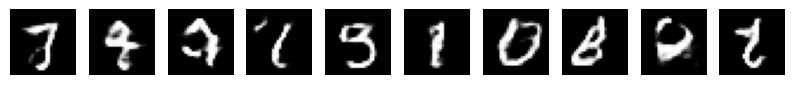

Current epoch is 40


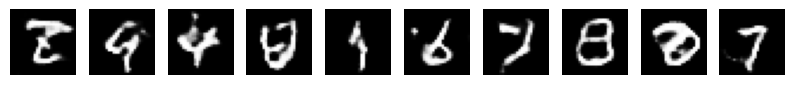

Current epoch is 41


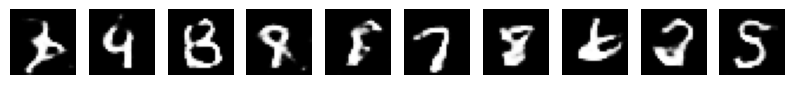

Current epoch is 42


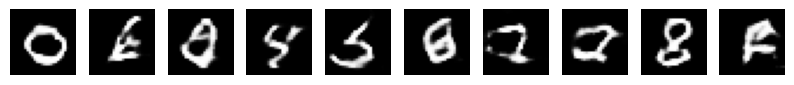

Current epoch is 43


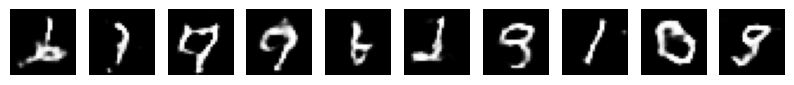

Current epoch is 44


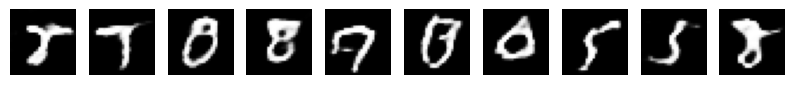

Current epoch is 45


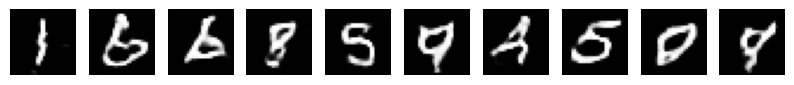

Current epoch is 46


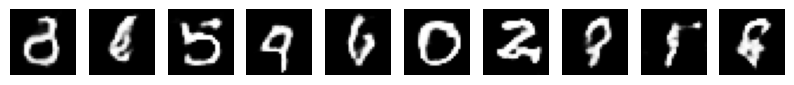

Current epoch is 47


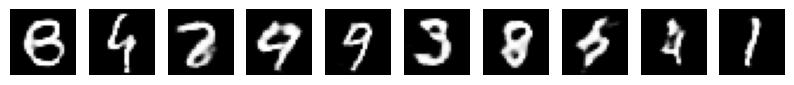

Current epoch is 48


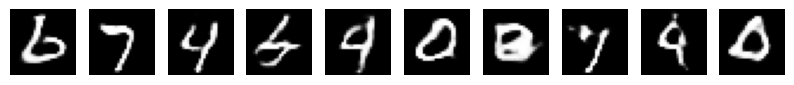

Current epoch is 49


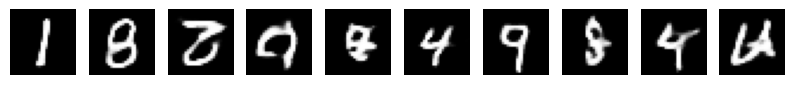

Current epoch is 50


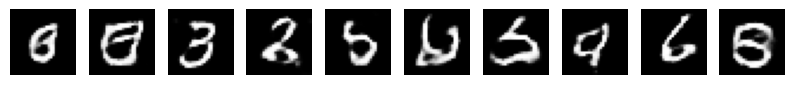

Current epoch is 51


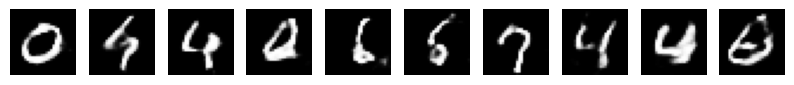

Current epoch is 52


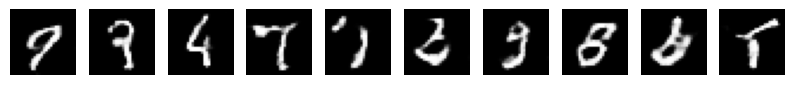

Current epoch is 53


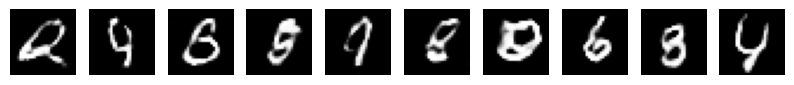

Current epoch is 54


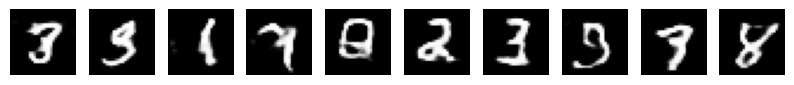

Current epoch is 55


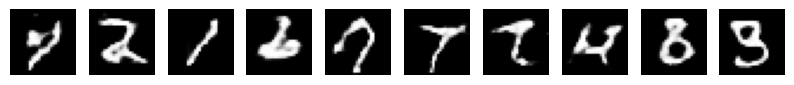

Current epoch is 56


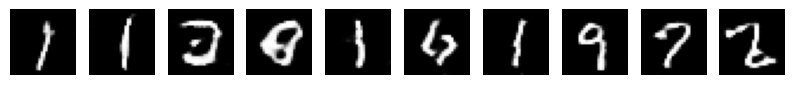

Current epoch is 57


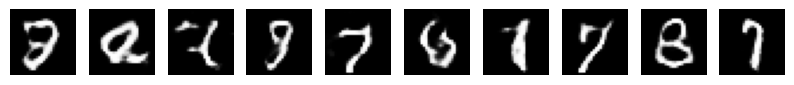

Current epoch is 58


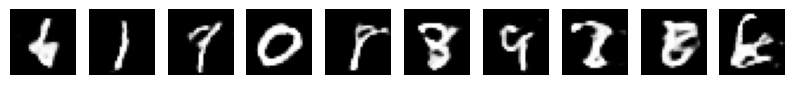

Current epoch is 59


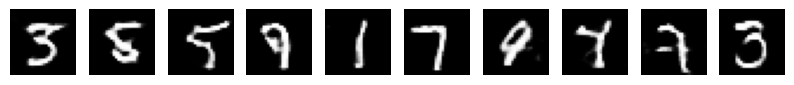

Current epoch is 60


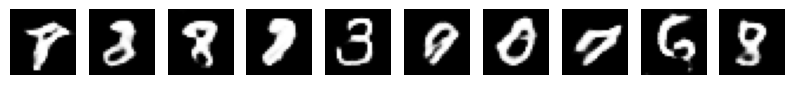

Current epoch is 61


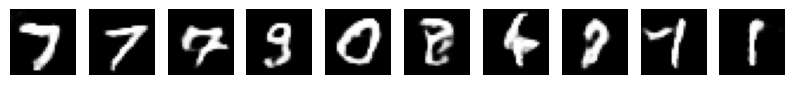

Current epoch is 62


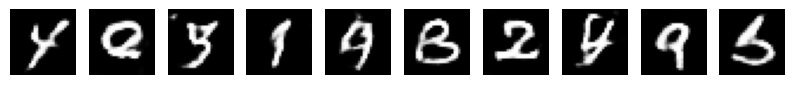

Current epoch is 63


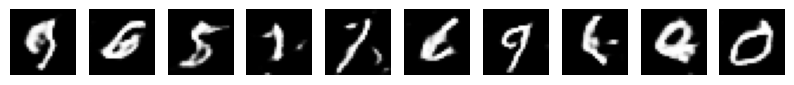

Current epoch is 64


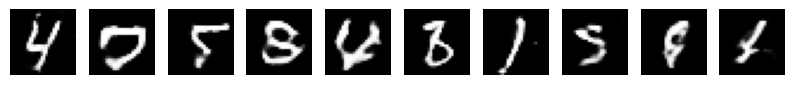

Current epoch is 65


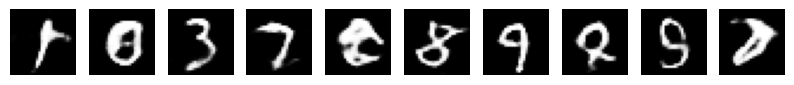

Current epoch is 66


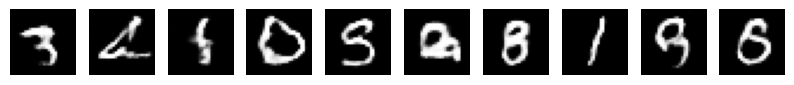

Current epoch is 67


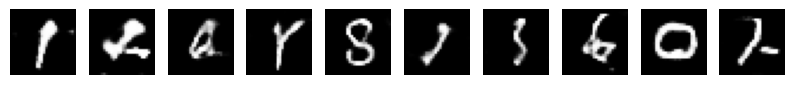

Current epoch is 68


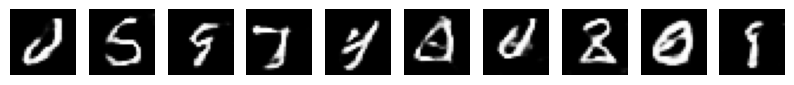

Current epoch is 69


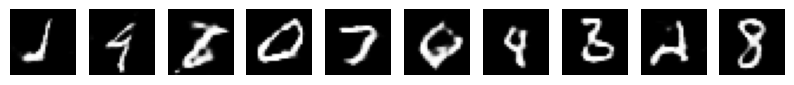

Current epoch is 70


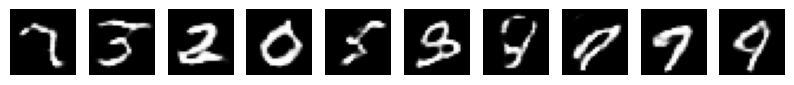

Current epoch is 71


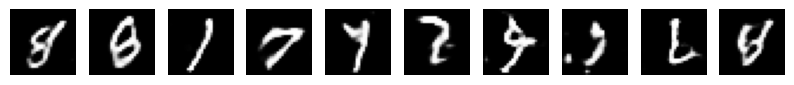

Current epoch is 72


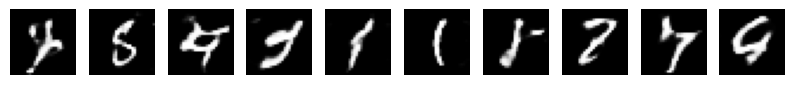

Current epoch is 73


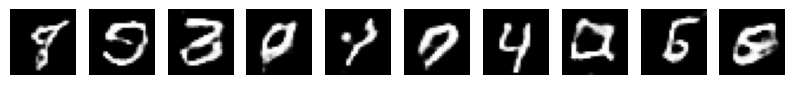

Current epoch is 74


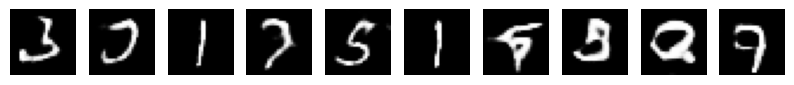

Current epoch is 75


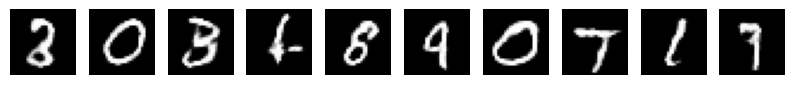

Current epoch is 76


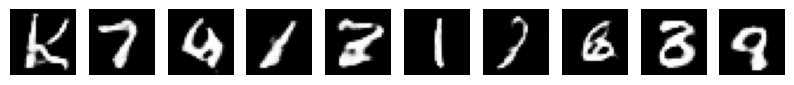

Current epoch is 77


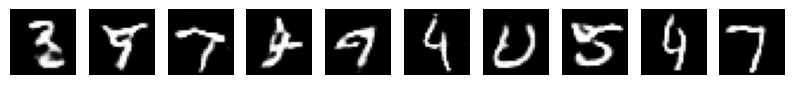

Current epoch is 78


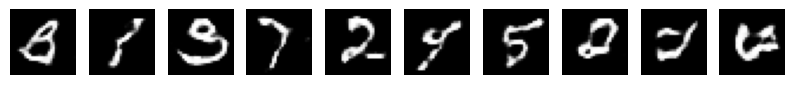

Current epoch is 79


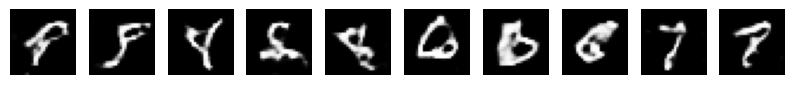

Current epoch is 80


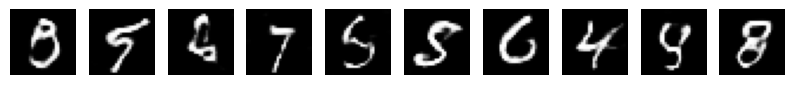

Current epoch is 81


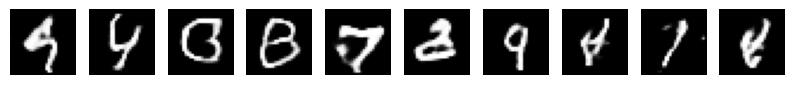

Current epoch is 82


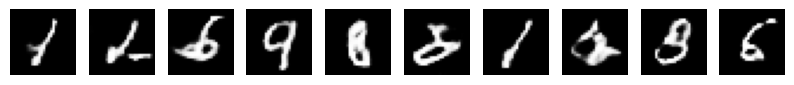

Current epoch is 83


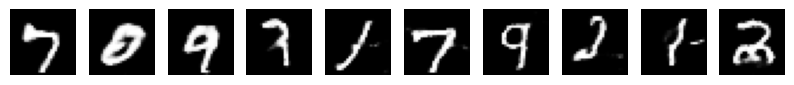

Current epoch is 84


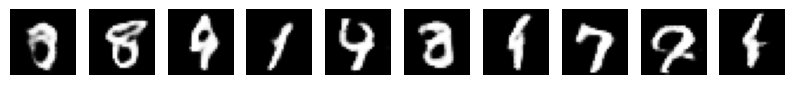

Current epoch is 85


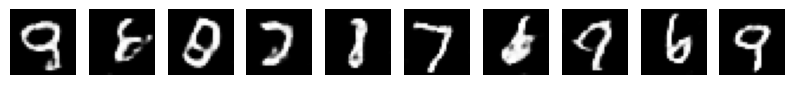

Current epoch is 86


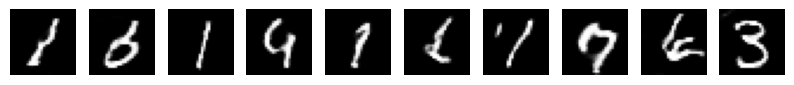

Current epoch is 87


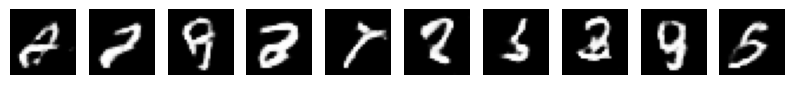

Current epoch is 88


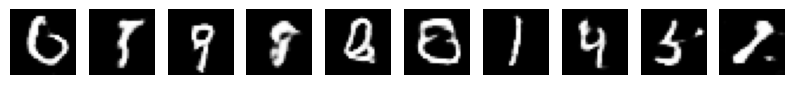

Current epoch is 89


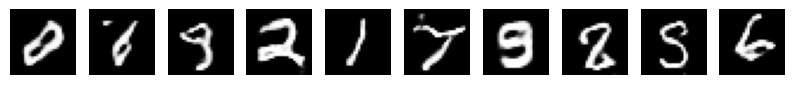

Current epoch is 90


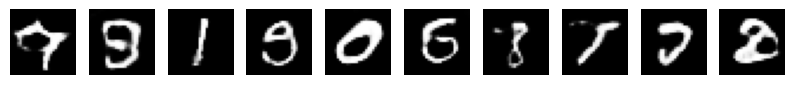

Current epoch is 91


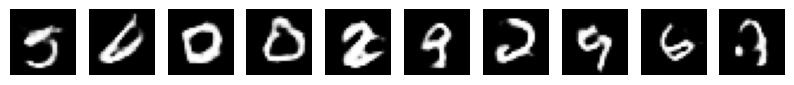

Current epoch is 92


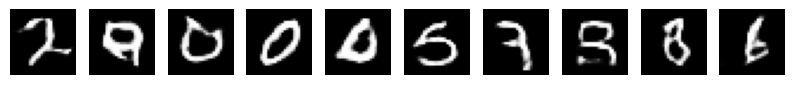

Current epoch is 93


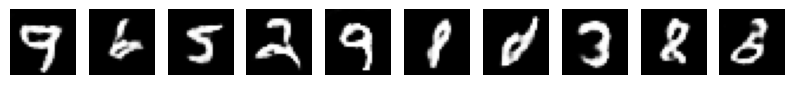

Current epoch is 94


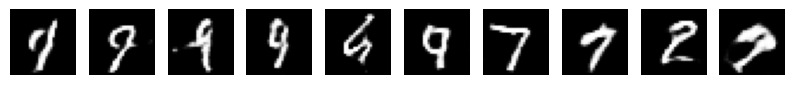

Current epoch is 95


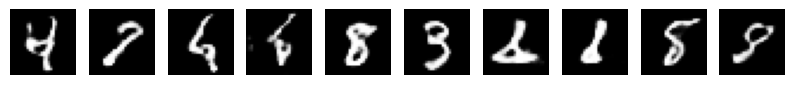

Current epoch is 96


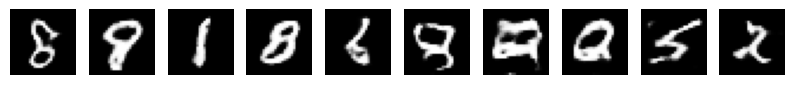

Current epoch is 97


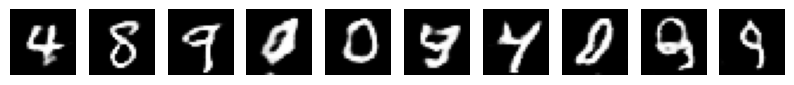

Current epoch is 98


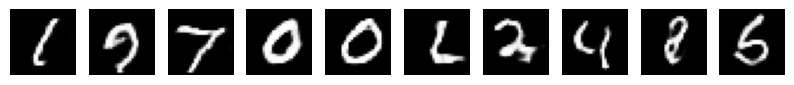

Current epoch is 99


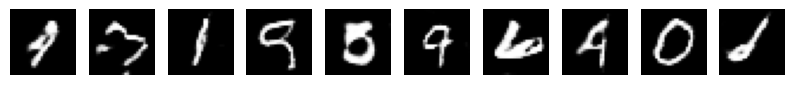

In [24]:
train(train_dataset, epochs=100)